In [ ]:
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols
from scipy.stats import zscore
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split,KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as sfs
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.linear_model import LinearRegression,RidgeCV,LassoCV,ElasticNetCV
import scipy.stats as stats
import pylab
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("elikplim/forest-fires-data-set")

print("Path to dataset files:", path)

100%|██████████| 7.10k/7.10k [00:00<00:00, 7.29MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/elikplim/forest-fires-data-set/versions/1


In [ ]:
import pandas as pd
forestfires = pd.read_csv(path + '/forestfires.csv')

In [ ]:
forestfires.dtypes

,0
X,int64
Y,int64
month,object
day,object
FFMC,float64
DMC,float64
DC,float64
ISI,float64
temp,float64
RH,int64


In [ ]:
forestfires.isna().sum()

,0
X,0
Y,0
month,0
day,0
FFMC,0
DMC,0
DC,0
ISI,0
temp,0
RH,0


# Exploratory data analysis

In [ ]:
forestfires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [ ]:
forestfires.describe().T

,count,mean,std,min,25%,50%,75%,max
X,517.0,4.669246,2.313778,1.0,3.0,4.00,7.00,9.00
Y,517.0,4.299807,1.229900,2.0,4.0,4.00,5.00,9.00
FFMC,517.0,90.644681,5.520111,18.7,90.2,91.60,92.90,96.20
DMC,517.0,110.872340,64.046482,1.1,68.6,108.30,142.40,291.30
DC,517.0,547.940039,248.066192,7.9,437.7,664.20,713.90,860.60
ISI,517.0,9.021663,4.559477,0.0,6.5,8.40,10.80,56.10
temp,517.0,18.889168,5.806625,2.2,15.5,19.30,22.80,33.30
RH,517.0,44.288201,16.317469,15.0,33.0,42.00,53.00,100.00
wind,517.0,4.017602,1.791653,0.4,2.7,4.00,4.90,9.40
rain,517.0,0.021663,0.295959,0.0,0.0,0.00,0.00,6.40


# Dependent variable

Skew: 12.846933533934868
Kurtosis: 194.1407210942299


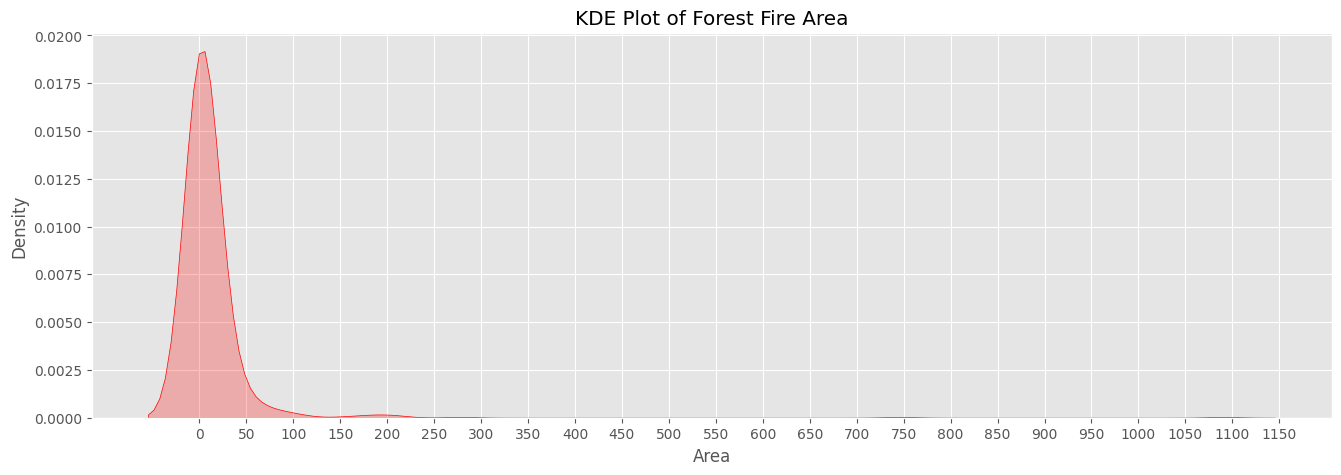

In [ ]:
plt.figure(figsize=(16,5))
print("Skew: {}".format(forestfires['area'].skew()))
print("Kurtosis: {}".format(forestfires['area'].kurtosis()))

ax = sns.kdeplot(data=forestfires['area'], fill=True, color='red')
ax.set_title('KDE Plot of Forest Fire Area')
ax.set_xlabel('Area')
ax.set_ylabel('Density')
plt.xticks([i for i in range(0,1200,50)])
plt.show()

- Skewness: A skewness of 12.85 indicates the distribution is highly positively skewed, meaning most area values are clustered on the lower end, with a few very high values pulling the tail to the right.
- Kurtosis: A kurtosis of 194.14 indicates extremely heavy tails, meaning the data has a few extreme outliers.
- Kernel density estimation: Most of the observations are concentrated near zero, and only a few areas have very high values.

# Independent variable

In [ ]:
def p_a(area):
  if area == 0.0:
    return "No damage"
  else:
    return "damaged"

In [ ]:
def p_a(area):
  if area == 0.0:
    return "No damage"
  elif area <= 1:
    return "low"
  elif area <= 25:
    return "moderate"
  else:
    return "high"

In [ ]:
forestfires

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


In [ ]:
forestfires['Presenceoffire'] = forestfires['area'].apply(p_a)
forestfires.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Presenceoffire
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


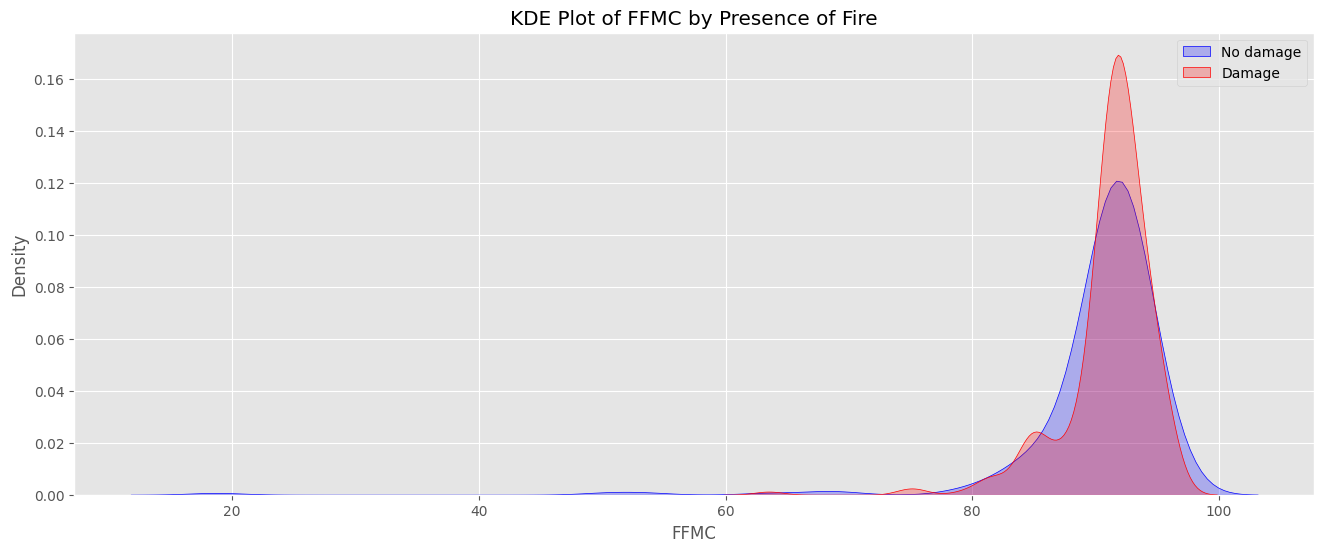

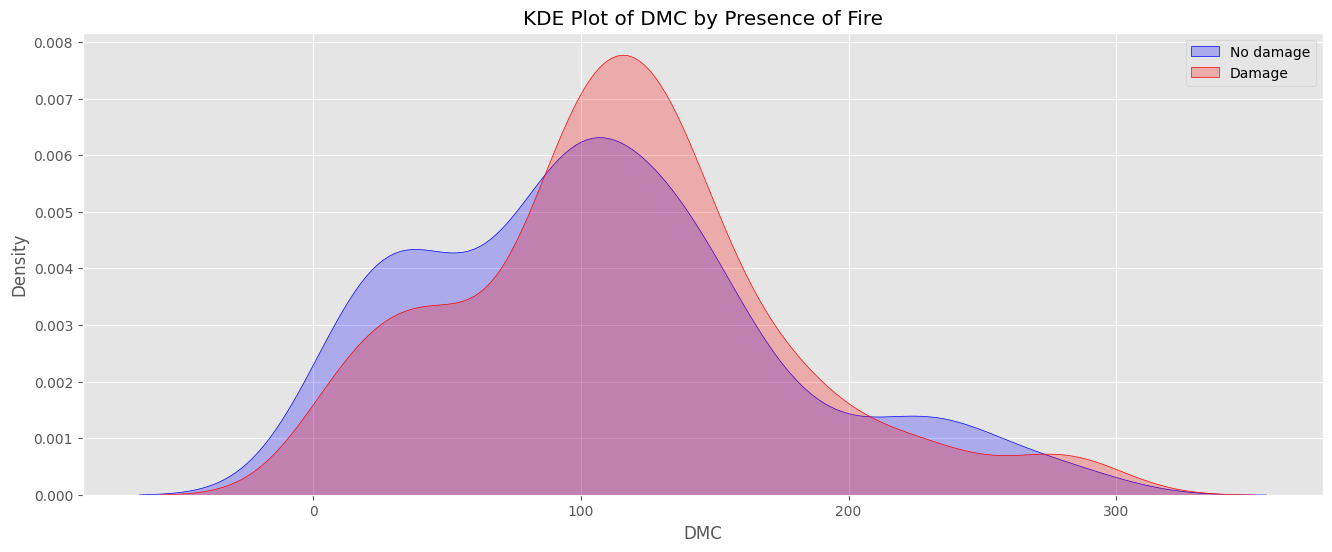

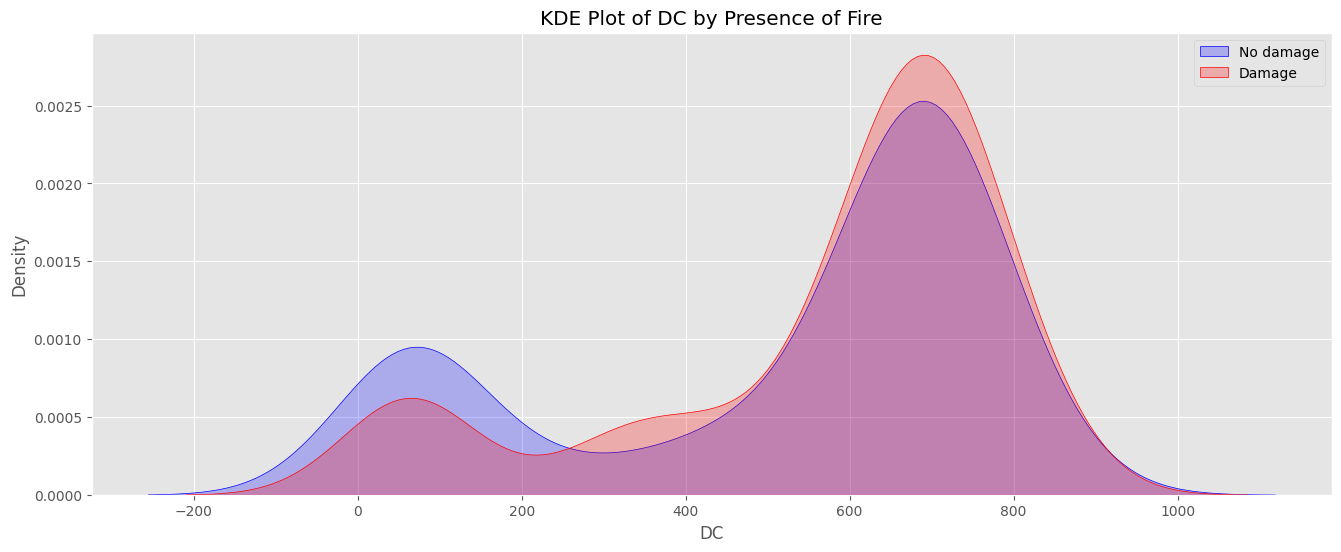

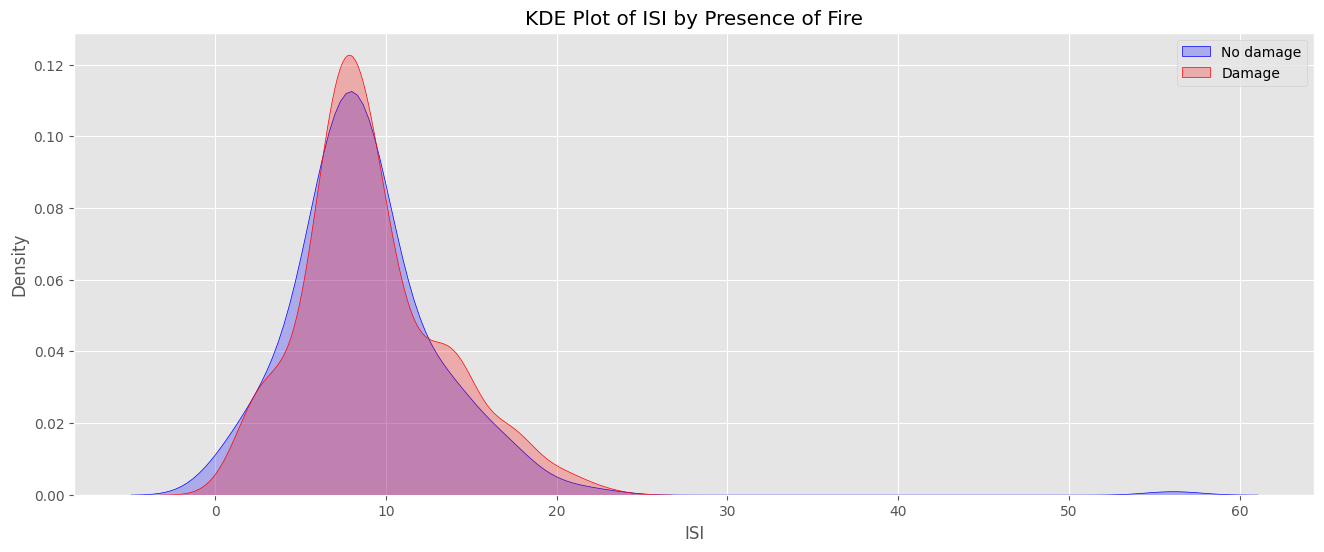

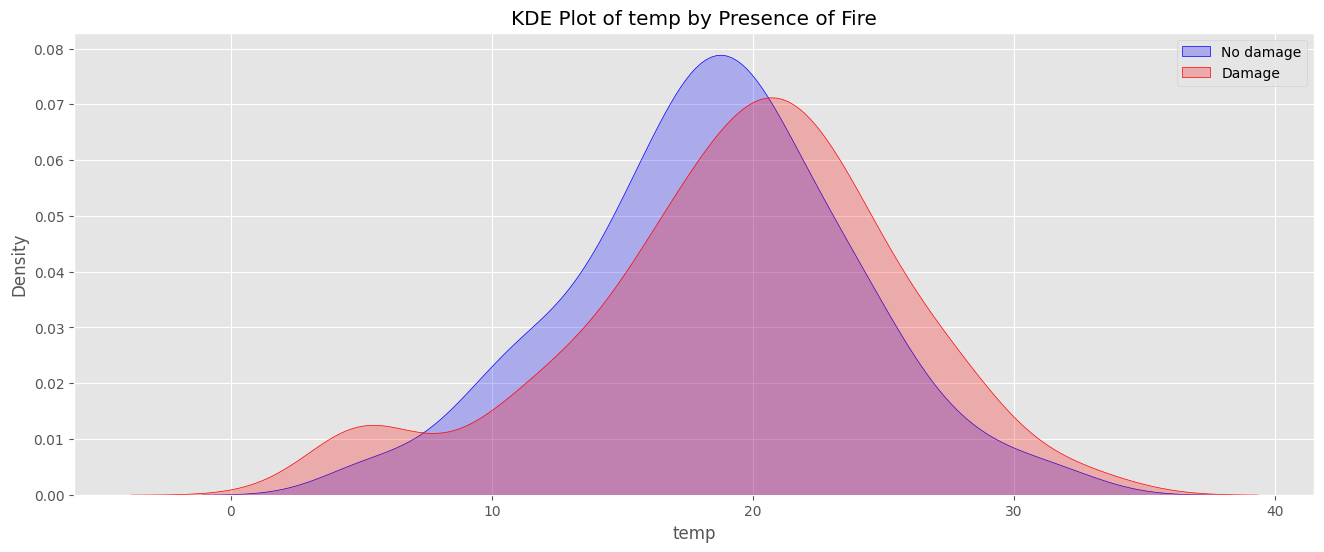

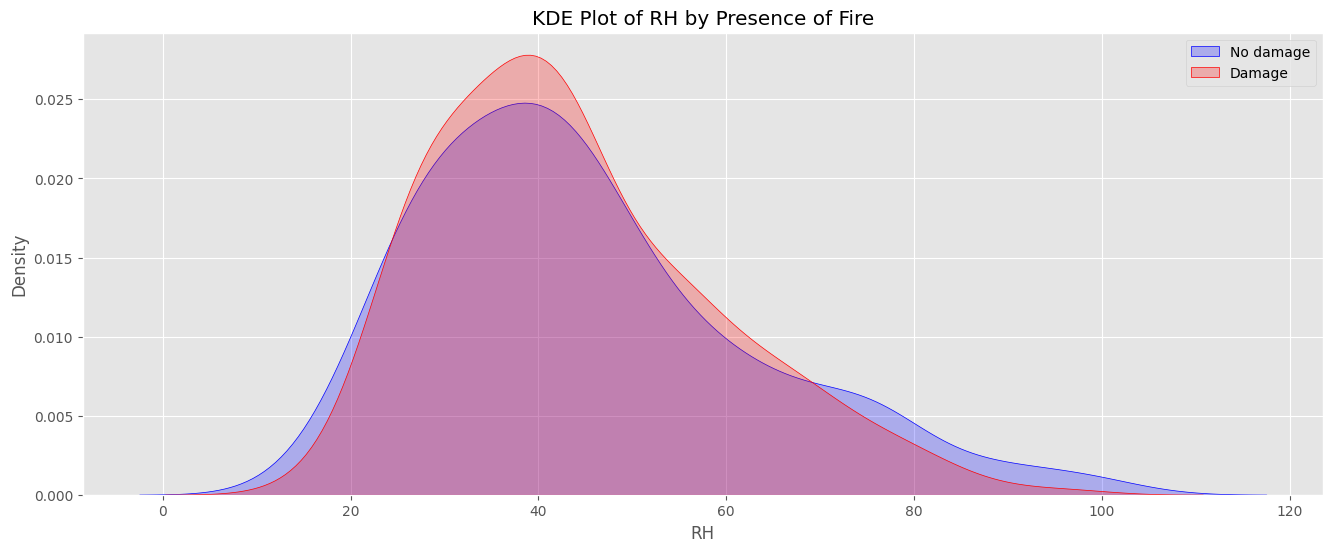

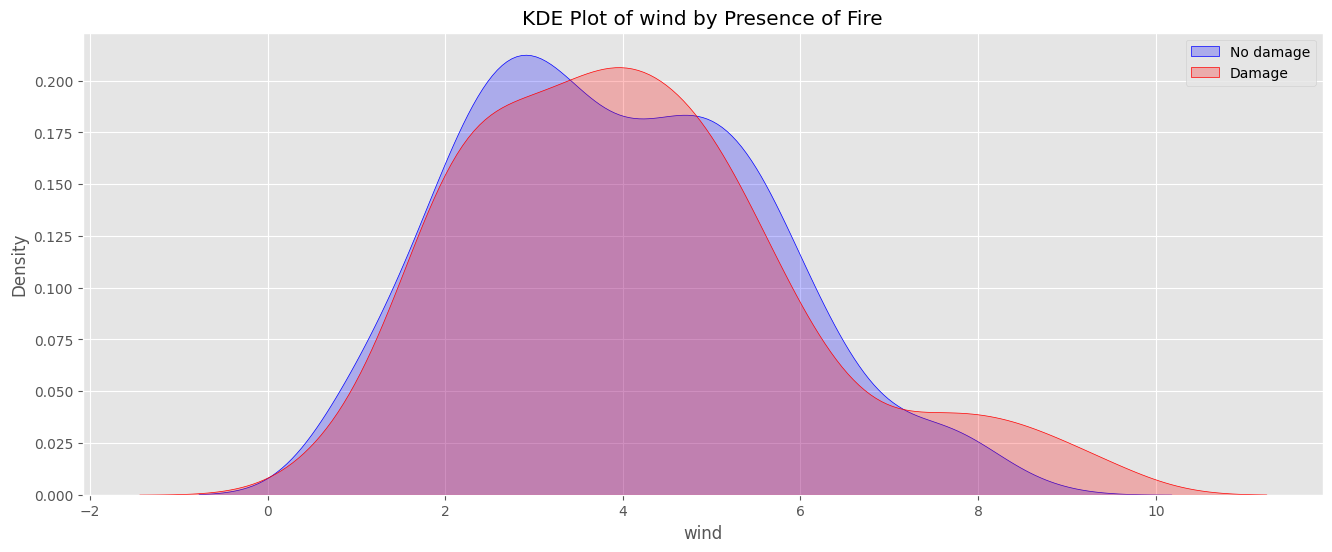

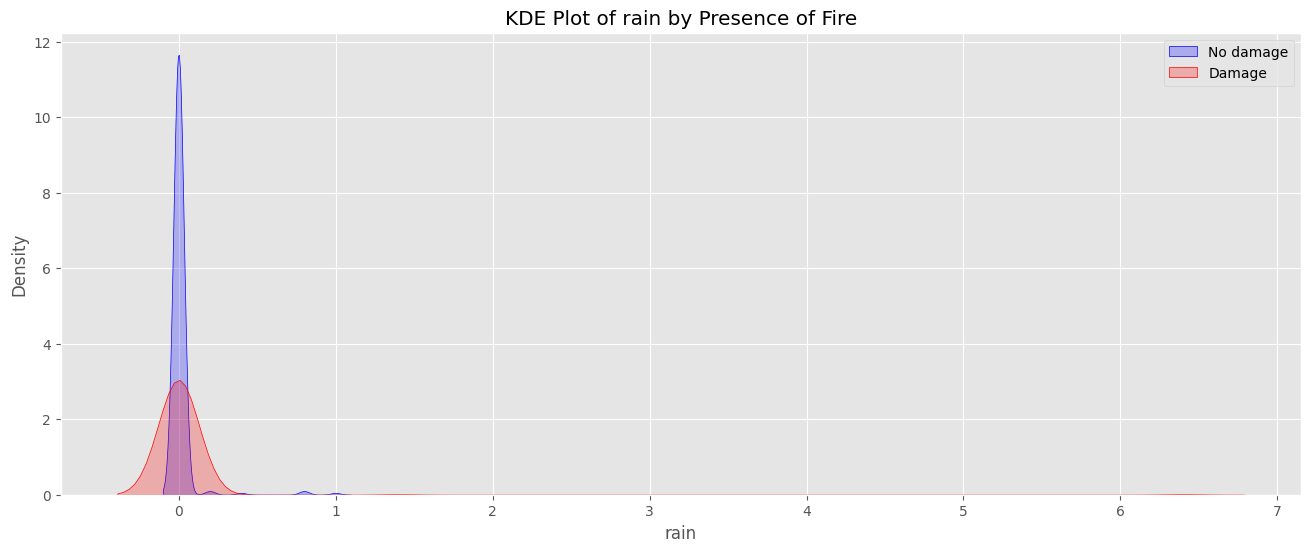

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

exclude_columns = ['X', 'Y', 'month', 'day', 'Presenceoffire', 'area']

columns_to_plot = [col for col in forestfires.columns if col not in exclude_columns]


for col in columns_to_plot:
    plt.figure(figsize=(16, 6))

    # No damage
    sns.kdeplot(data=forestfires[forestfires['Presenceoffire'] == "No damage"][col],
                fill=True, color='blue', label='No damage')

    # Damage
    sns.kdeplot(data=forestfires[forestfires['Presenceoffire'] == "damaged"][col],
                fill=True, color='red', label='Damage')

    plt.title(f'KDE Plot of {col} by Presence of Fire')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

exclude_columns = ['X', 'Y', 'month', 'day', 'Presenceoffire', 'area']

columns_to_plot = [col for col in forestfires.columns if col not in exclude_columns]

color_mapping = {
    "No damage": "blue",
    "low": "cyan",
    "moderate": "green",
    "high": "orange"
}

for col in columns_to_plot:
    plt.figure(figsize=(16, 6))

    for fire_level, color in color_mapping.items():
        sns.kdeplot(
            data=forestfires[forestfires['Presenceoffire'] == fire_level][col],
            fill=True, color=color, label=fire_level
        )

    plt.title(f'KDE Plot of {col} by Presence of Fire')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()
    plt.show()

In [ ]:
numeric_columns = ['FFMC','DMC','DC','ISI','temp','RH','wind','rain']
num_data = forestfires[numeric_columns]
pd.DataFrame(data=[num_data.skew(),num_data.kurtosis()],index=['skewness','kurtosis'])

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
skewness,-6.575606,0.547498,-1.100445,2.536325,-0.331172,0.862904,0.571001,19.816344
kurtosis,67.066041,0.204822,-0.245244,21.458037,0.136166,0.438183,0.054324,421.295964


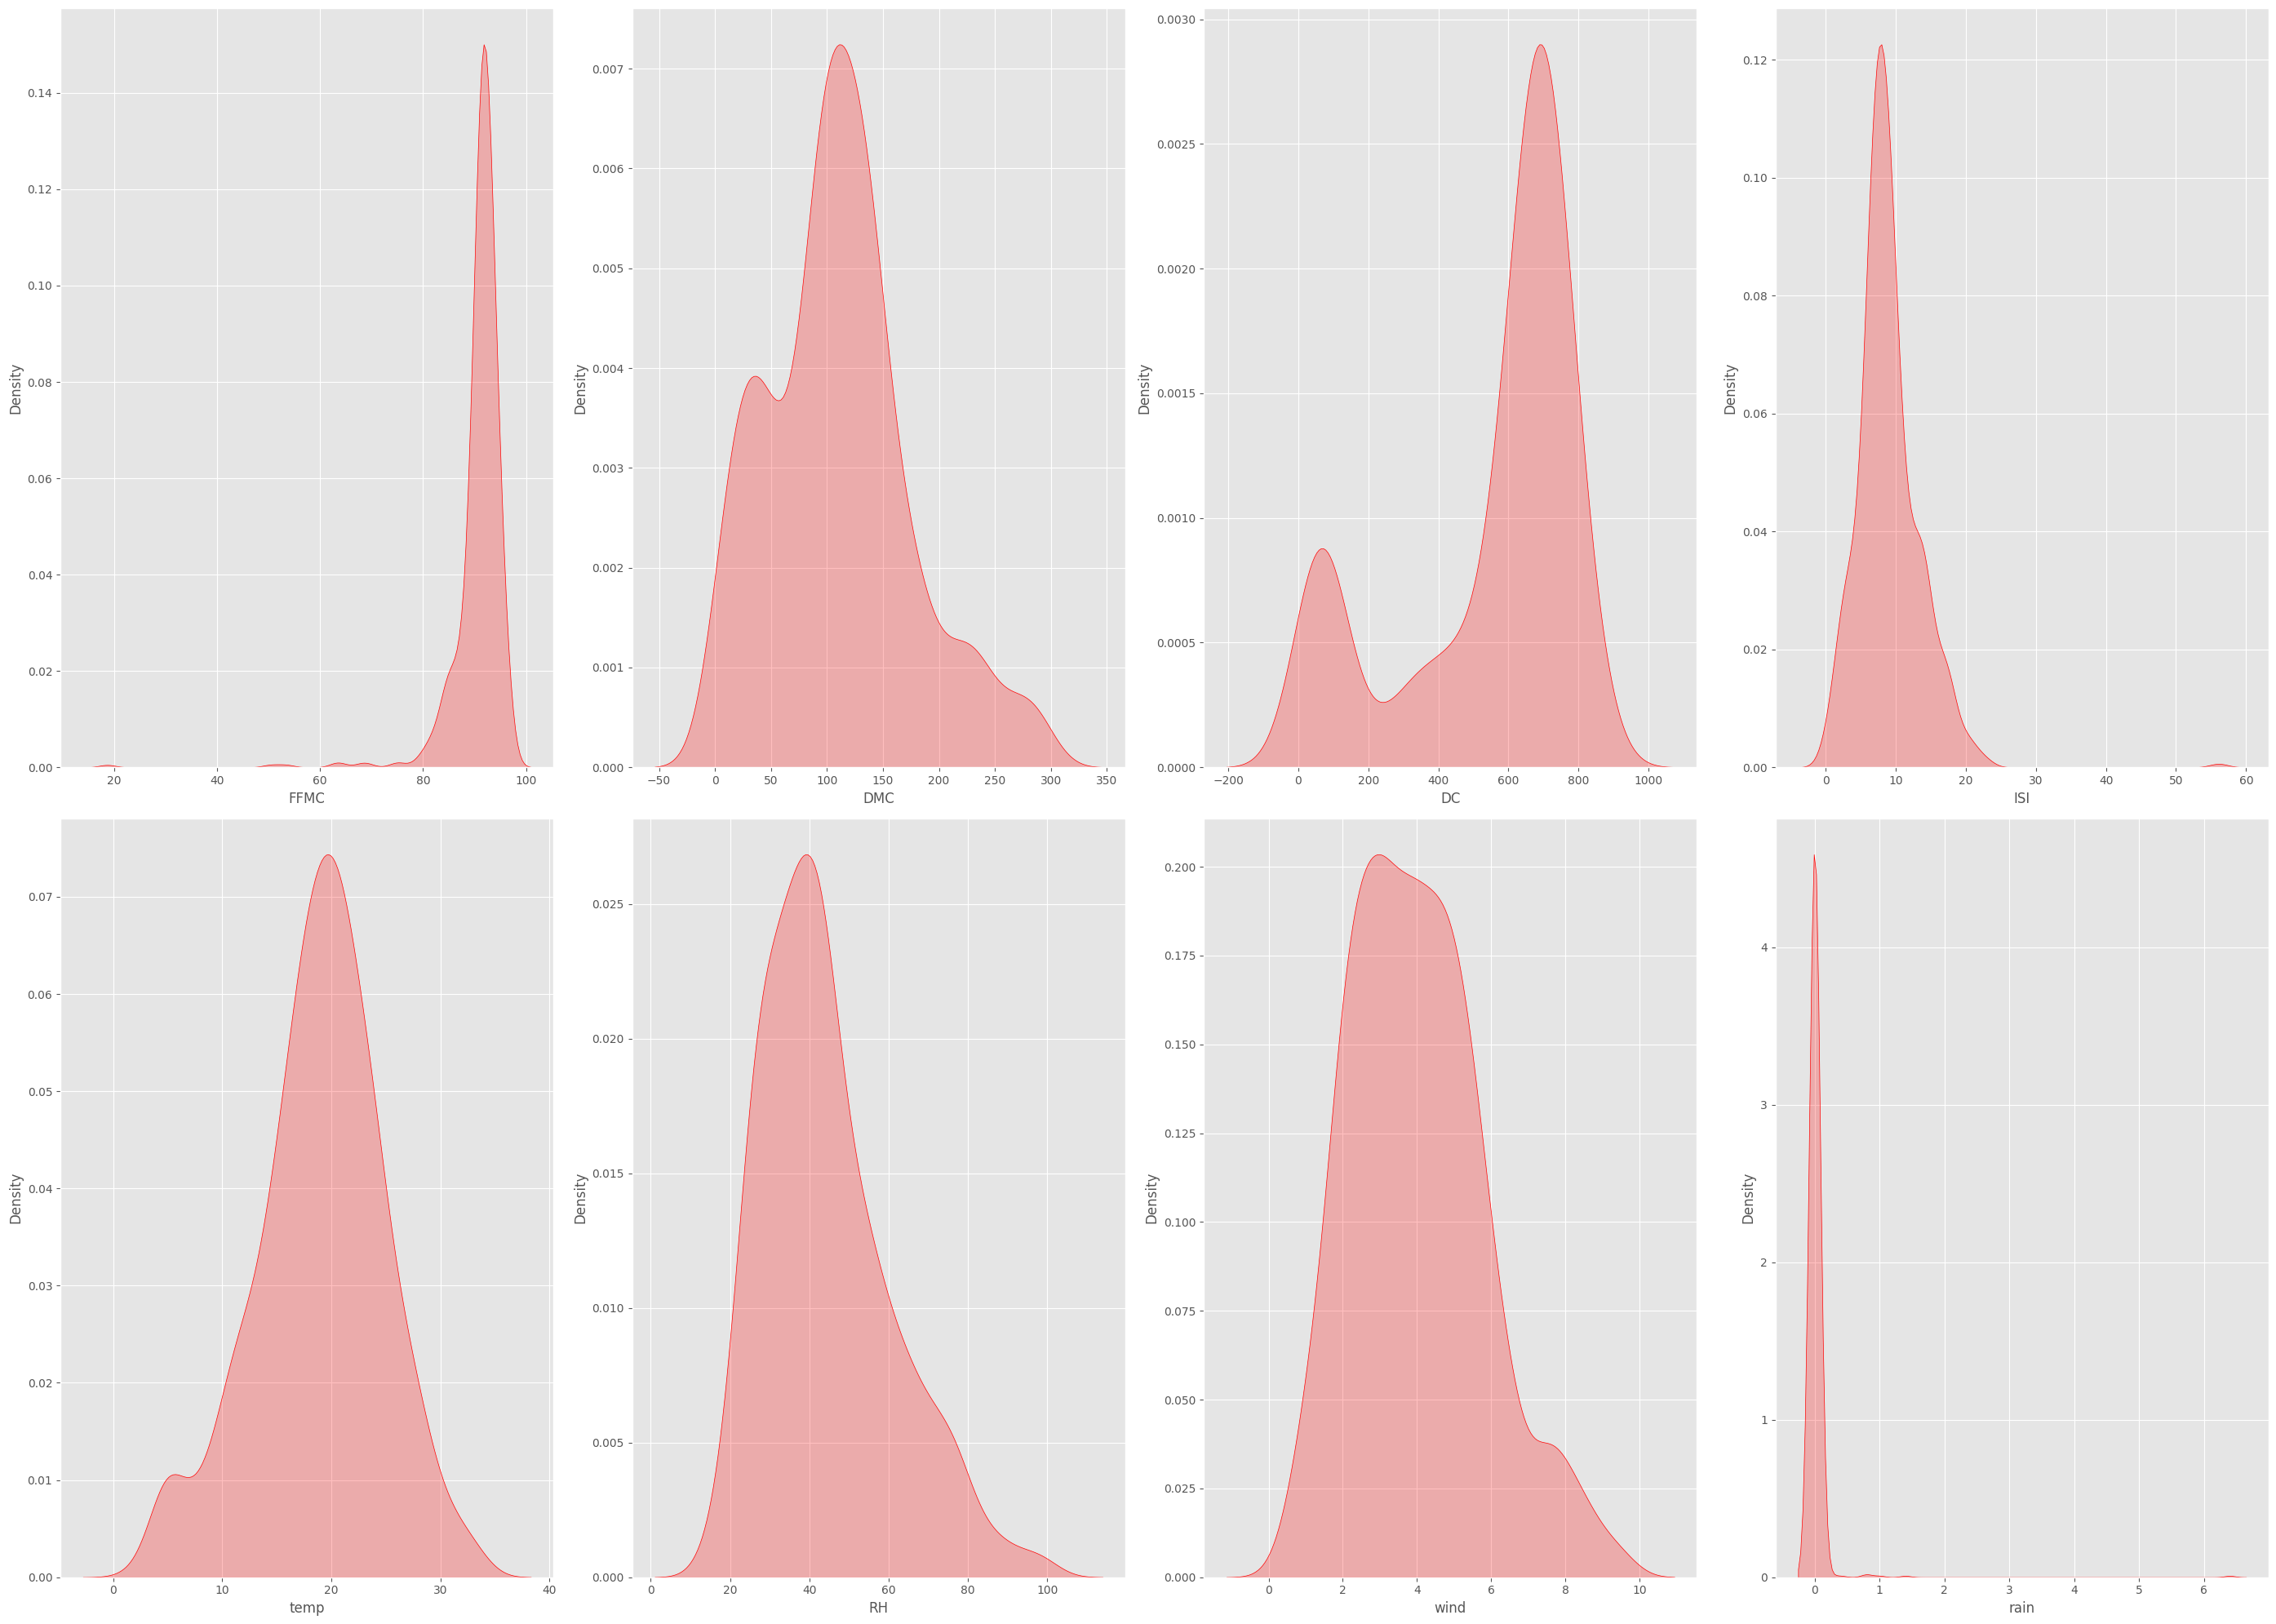

In [ ]:
plt.figure(figsize=(28,20))
for i,col in enumerate(numeric_columns,1):
    plt.subplot(2,4,i)
    sns.kdeplot(forestfires[col],color='r',fill=True)
plt.tight_layout()
plt.show()

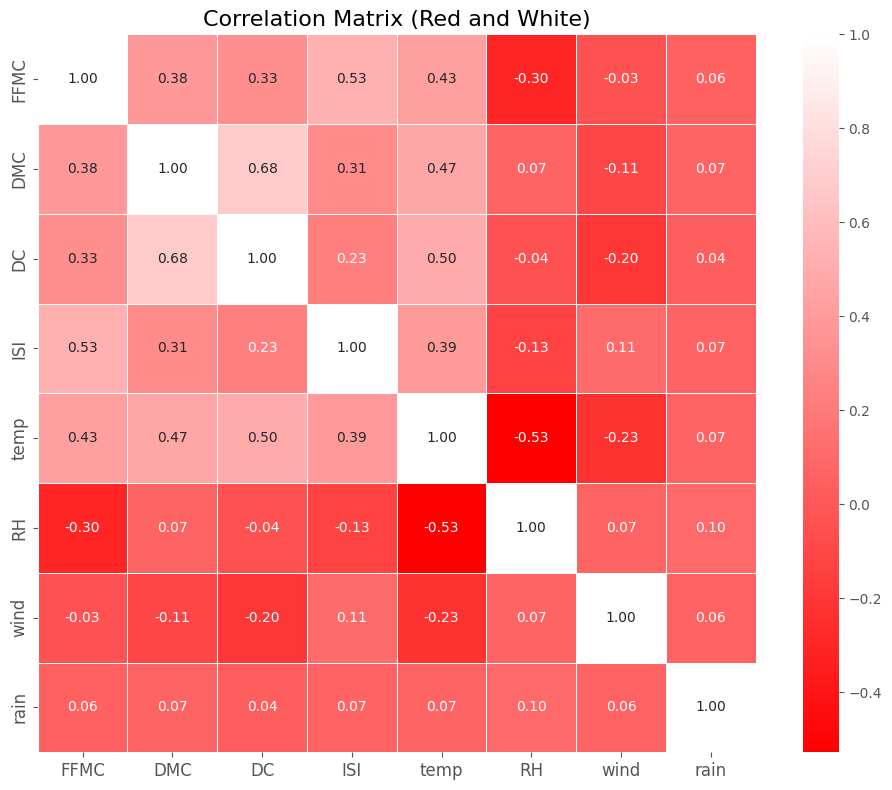

In [ ]:
id_forestfires = forestfires[['FFMC','DMC','DC','ISI','temp','RH','wind','rain']]
correlation_matrix = id_forestfires.corr()
red_black_cmap = LinearSegmentedColormap.from_list("RedBlack", ["red", "white"])

plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap=red_black_cmap,
    cbar=True,
    square=True,
    linewidths=0.5,
    linecolor="white"
)
plt.title("Correlation Matrix (Red and White)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Degree of Damage by Time

In [ ]:
def area_damage(area):
    if area == 0.0:
        return "No damage"
    elif area <= 1:
        return "low"
    elif area <= 25:
        return "moderate"
    elif area <= 100:
        return "high"
    else:
        return "very high"

forestfires['Degree_of_damage'] = forestfires['area'].apply(area_damage)
forestfires.head()



,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,Degree_of_damage
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,No damage
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,No damage
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,No damage
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,No damage
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,No damage


In [ ]:
time_columns = forestfires[['month','day']]

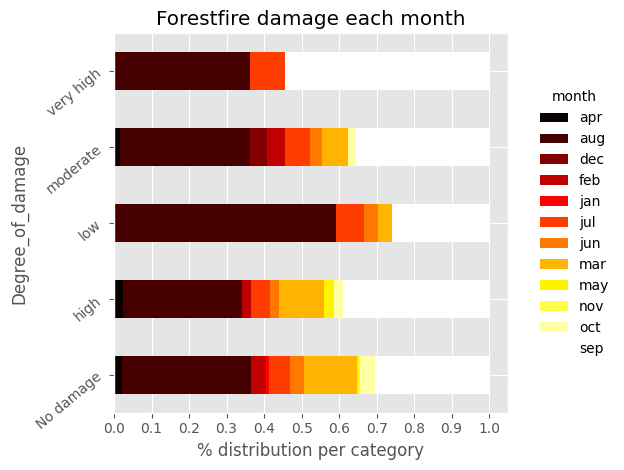

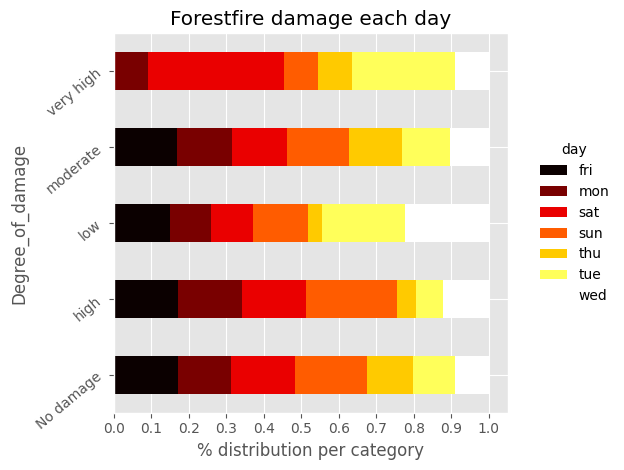

In [ ]:
for column in time_columns:
    cross = pd.crosstab(index=forestfires['Degree_of_damage'], columns=forestfires[column], normalize='index')
    ax = cross.plot.barh(stacked=True, rot=40, cmap='hot')
    plt.xlabel('% distribution per category')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.title(f"Forestfire damage each {column}")
    # Move the legend to the right
    plt.legend(title=column, bbox_to_anchor=(1.05, 0.5), loc='center left', frameon=False)
    plt.tight_layout()
plt.show()


# Fire frequency per coordinate analysis

In [ ]:
forestfires

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,coordinate_count
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,11
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,45
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,45
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,52
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,22
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,27
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,45
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,15


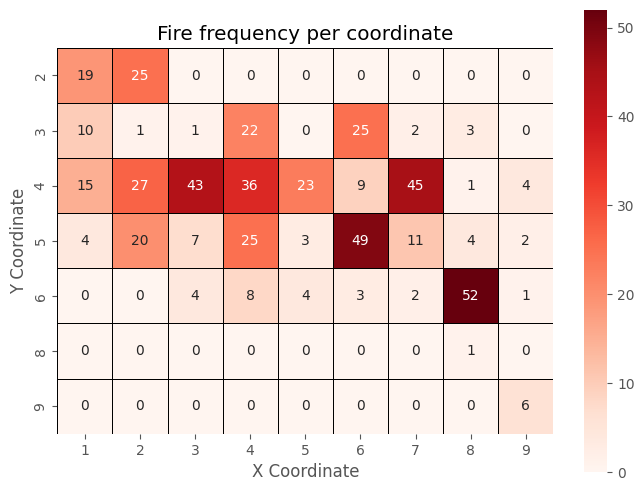

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Cap the maximum area value and bin into custom ranges
forestfires["area"] = np.clip(forestfires["area"], 0, 1090)
bins = [0,1200]  # Define custom bins
forestfires["area_bins"] = pd.cut(forestfires["area"], bins=bins, right=False)

# Create a 9x9 heatmap for each bin
for bin_range in forestfires["area_bins"].cat.categories:
    # Filter data for the current bin range
    filtered_data = forestfires[forestfires["area_bins"] == bin_range]

    # Create a pivot table for counts of data points in the grid
    heatmap_data = filtered_data.pivot_table(
        index="Y", columns="X", values="area", aggfunc="count", fill_value=0
    )

    # Plot the heatmap for the current bin
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt="d",
        cmap="Reds",
        cbar=True,
        linewidths=0.5,
        linecolor="black",
        square=True,
        vmin=0,  # Ensure consistent color scaling across bins
    )
    plt.title("Fire frequency per coordinate")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [ ]:
filtered_data

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,coordinate_count
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,11
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,45
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,45
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,52
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,22
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,27
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,45
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,15


# Outliers

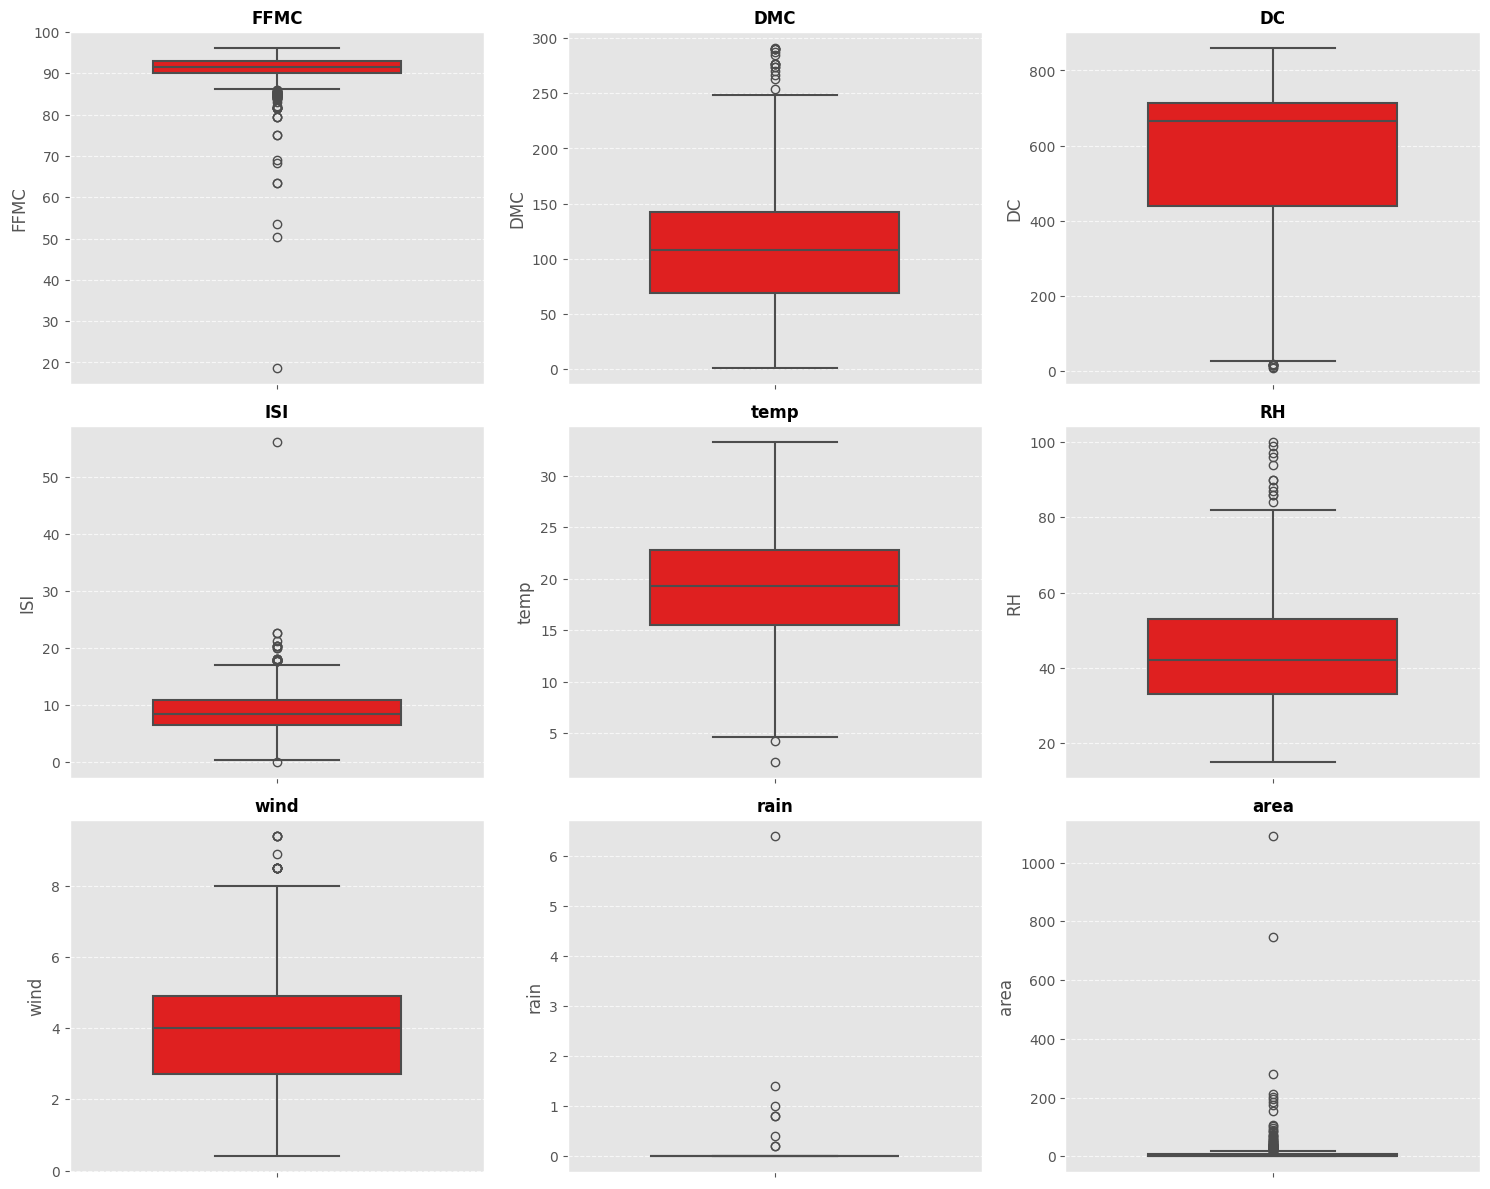

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical columns
numeric_columns = ['FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'area']

# Create boxplots for each numerical column using Seaborn for better styling
plt.figure(figsize=(15, 12))  # Increase figure size for better spacing
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)  # Arrange in a 3x3 grid
    sns.boxplot(data=forestfires[col], color="red", width=0.6, linewidth=1.5)
    plt.title(col, fontsize=12, fontweight="bold")
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid for better readability

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

# Regression

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.stats import t

# Filter data to include fires with area <= 10
filtered_fires = forestfires[forestfires['area'] <= 10].copy()

# Log-transform the target variable (area)
filtered_fires['ln_area'] = np.log1p(filtered_fires['area'])

# Define features and target (only 'temp', 'RH', 'wind', 'rain')
X = filtered_fires[['temp', 'RH', 'wind', 'rain']]
y = filtered_fires['ln_area']
W
# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a parameter grid for GridSearchCV
param_grid = {
    'C': [3],  # Fixed value from the paper
    'epsilon': [0.1, 0.2, 0.5],  # Example range for epsilon
    'gamma': [2**-9, 2**-7, 2**-5, 2**-3, 2**-1]  # From the paper
}

# Perform GridSearchCV with 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Use the best parameters
best_params = grid_search.best_params_
model = SVR(kernel='rbf', C=best_params['C'], epsilon=best_params['epsilon'], gamma=best_params['gamma'])

# Repeat 10-fold cross-validation with reshuffling for 30 runs
mad_scores = []
rmse_scores = []

for run in range(30):  # 30 repetitions
    X_shuffled, y_shuffled = shuffle(X_scaled, y, random_state=42 + run)
    kf = KFold(n_splits=10, shuffle=True, random_state=42 + run)

    for train_index, test_index in kf.split(X_shuffled):
        X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
        y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)  # Reverse log transform
        y_true = np.expm1(y_test)

        # Calculate MAD
        mad = mean_absolute_error(y_true, y_pred)
        mad_scores.append(mad)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_scores.append(rmse)

# Calculate the mean MAD, mean RMSE, and their confidence intervals using t-student distribution
mean_mad = np.mean(mad_scores)
mean_rmse = np.mean(rmse_scores)

std_error = np.std(mad_scores, ddof=1) / np.sqrt(len(mad_scores))
t_value = t.ppf(0.975, len(mad_scores) - 1)  # 95% confidence level
confidence_interval = t_value * std_error

# Print the results
print(f"Optimized Mean MAD for fires with area <= 10 (SVR): {mean_mad:.2f}")
print(f"Mean RMSE for fires with area <= 10 (SVR): {mean_rmse:.2f}")
print(f"95% Confidence Interval for MAD: ±{confidence_interval:.2f}")

Optimized Mean MAD for fires with area <= 10 (SVR): 1.57
Mean RMSE for fires with area <= 10 (SVR): 2.89
95% Confidence Interval for MAD: ±0.04


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
from scipy.stats import t

# Filter data to include fires with area <= 10
filtered_fires = forestfires[forestfires['area'] <= 10].copy()

# Log-transform the target variable (area)
filtered_fires['ln_area'] = np.log1p(filtered_fires['area'])

# Define features and target (only 'temp', 'RH', 'wind', 'rain')
X = filtered_fires[['temp', 'RH', 'wind', 'rain']]
y = filtered_fires['ln_area']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the parameter grids for each model
param_grid_adaboost = {
    'n_estimators': [25, 50, 75, 100, 125, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

param_grid_bagging = {
    'n_estimators': [10, 25, 50, 75, 100],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

param_grid_lgb = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0]
}

# Helper function to calculate MAD, RMSE and confidence intervals
def evaluate_model(model, X, y, n_runs=30):
    mad_scores = []
    rmse_scores = []
    for run in range(n_runs):
        X_shuffled, y_shuffled = shuffle(X, y, random_state=42 + run)
        kf = KFold(n_splits=10, shuffle=True, random_state=42 + run)
        for train_index, test_index in kf.split(X_shuffled):
            X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
            y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]

            model.fit(X_train, y_train)
            y_pred_log = model.predict(X_test)
            y_pred = np.expm1(y_pred_log)  # Reverse log transform
            y_true = np.expm1(y_test)

            # Calculate MAD
            mad = mean_absolute_error(y_true, y_pred)
            mad_scores.append(mad)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            rmse_scores.append(rmse)

    mean_mad = np.mean(mad_scores)
    mean_rmse = np.mean(rmse_scores)
    std_error = np.std(mad_scores, ddof=1) / np.sqrt(len(mad_scores))
    t_value = t.ppf(0.975, len(mad_scores) - 1)  # 95% confidence level
    confidence_interval = t_value * std_error
    return mean_mad, mean_rmse, confidence_interval

# AdaBoost
base_estimator = DecisionTreeRegressor(random_state=42)
adaboost = AdaBoostRegressor(estimator=base_estimator, random_state=42)
random_search_adaboost = RandomizedSearchCV(
    estimator=adaboost, param_distributions=param_grid_adaboost, n_iter=20,
    scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1, random_state=42
)
random_search_adaboost.fit(X_scaled, y)
best_params_adaboost = random_search_adaboost.best_params_
optimized_adaboost = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=best_params_adaboost['estimator__max_depth'], random_state=42),
    n_estimators=best_params_adaboost['n_estimators'],
    learning_rate=best_params_adaboost['learning_rate'],
    random_state=42
)
mean_mad_adaboost, mean_rmse_adaboost, ci_adaboost = evaluate_model(optimized_adaboost, X_scaled, y)

# XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42), param_distributions=param_grid_xgb,
    n_iter=20, scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1, random_state=42
)
random_search_xgb.fit(X_scaled, y)
best_params_xgb = random_search_xgb.best_params_
optimized_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params_xgb)
mean_mad_xgb, mean_rmse_xgb, ci_xgb = evaluate_model(optimized_xgb, X_scaled, y)

# Bagging
bagging = BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42), random_state=42)
random_search_bagging = RandomizedSearchCV(
    estimator=bagging, param_distributions=param_grid_bagging, n_iter=20,
    scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1, random_state=42
)
random_search_bagging.fit(X_scaled, y)
best_params_bagging = random_search_bagging.best_params_
optimized_bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    n_estimators=best_params_bagging['n_estimators'],
    max_samples=best_params_bagging['max_samples'],
    max_features=best_params_bagging['max_features'],
    random_state=42
)
mean_mad_bagging, mean_rmse_bagging, ci_bagging = evaluate_model(optimized_bagging, X_scaled, y)

# LightGBM
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
random_search_lgb = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(objective='regression', random_state=42), param_distributions=param_grid_lgb,
    n_iter=20, scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1, random_state=42
)
random_search_lgb.fit(X_scaled, y)
best_params_lgb = random_search_lgb.best_params_
optimized_lgb = lgb.LGBMRegressor(objective='regression', random_state=42, **best_params_lgb)
mean_mad_lgb, mean_rmse_lgb, ci_lgb = evaluate_model(optimized_lgb, X_scaled, y)

# Voting Regressor
voting_model = VotingRegressor(estimators=[('adaboost', optimized_adaboost),
                                           ('xgb', optimized_xgb),
                                           ('bagging', optimized_bagging),
                                           ('lgb', optimized_lgb)])
mean_mad_voting, mean_rmse_voting, ci_voting = evaluate_model(voting_model, X_scaled, y)

# Stacking Regressor
stacking_model = StackingRegressor(
    estimators=[('adaboost', optimized_adaboost),
                ('xgb', optimized_xgb),
                ('bagging', optimized_bagging),
                ('lgb', optimized_lgb)],
    final_estimator=LinearRegression()
)
mean_mad_stacking, mean_rmse_stacking, ci_stacking = evaluate_model(stacking_model, X_scaled, y)

# Print Results
print(f"AdaBoost - Optimized Mean MAD: {mean_mad_adaboost:.2f}, RMSE: {mean_rmse_adaboost:.2f}, 95% CI: ±{ci_adaboost:.2f}")
print(f"XGBoost - Optimized Mean MAD: {mean_mad_xgb:.2f}, RMSE: {mean_rmse_xgb:.2f}, 95% CI: ±{ci_xgb:.2f}")
print(f"Bagging - Optimized Mean MAD: {mean_mad_bagging:.2f}, RMSE: {mean_rmse_bagging:.2f}, 95% CI: ±{ci_bagging:.2f}")
print(f"LightGBM - Optimized Mean MAD: {mean_mad_lgb:.2f}, RMSE: {mean_rmse_lgb:.2f}, 95% CI: ±{ci_lgb:.2f}")
print(f"Voting Regressor - Optimized Mean MAD: {mean_mad_voting:.2f}, RMSE: {mean_rmse_voting:.2f}, 95% CI: ±{ci_voting:.2f}")
print(f"Stacking Regressor - Optimized Mean MAD: {mean_mad_stacking:.2f}, RMSE: {mean_rmse_stacking:.2f}, 95% CI: ±{ci_stacking:.2f}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from scipy.stats import t

# Filter data to include fires with area <= 10
filtered_fires = forestfires[forestfires['area'] <= 1000].copy()

# Log-transform the target variable (area)
filtered_fires['ln_area'] = np.log1p(filtered_fires['area'])

# Define features and target (only 'temp', 'RH', 'wind', 'rain')
X = filtered_fires[['temp', 'RH', 'wind', 'rain']]
y = filtered_fires['ln_area']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a parameter grid for GridSearchCV
param_grid = {
    'C': [3],  # Fixed value from the paper
    'epsilon': [0.1, 0.2, 0.5],  # Example range for epsilon
    'gamma': [2**-9, 2**-7, 2**-5, 2**-3, 2**-1]  # From the paper
}

# Perform GridSearchCV with 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(SVR(kernel='rbf'), param_grid, scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1)
grid_search.fit(X_scaled, y)

# Use the best parameters
best_params = grid_search.best_params_
model = SVR(kernel='rbf', C=best_params['C'], epsilon=best_params['epsilon'], gamma=best_params['gamma'])

# Repeat 10-fold cross-validation with reshuffling for 30 runs
mad_scores = []
rmse_scores = []

for run in range(30):  # 30 repetitions
    X_shuffled, y_shuffled = shuffle(X_scaled, y, random_state=42 + run)
    kf = KFold(n_splits=10, shuffle=True, random_state=42 + run)

    for train_index, test_index in kf.split(X_shuffled):
        X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
        y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]

        model.fit(X_train, y_train)
        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)  # Reverse log transform
        y_true = np.expm1(y_test)

        # Calculate MAD
        mad = mean_absolute_error(y_true, y_pred)
        mad_scores.append(mad)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_scores.append(rmse)

# Calculate the mean MAD, mean RMSE, and their confidence intervals using t-student distribution
mean_mad = np.mean(mad_scores)
mean_rmse = np.mean(rmse_scores)

std_error = np.std(mad_scores, ddof=1) / np.sqrt(len(mad_scores))
t_value = t.ppf(0.975, len(mad_scores) - 1)  # 95% confidence level
confidence_interval = t_value * std_error

# Print the results
print(f"Optimized Mean MAD for fires with area <= 1000 (SVR): {mean_mad:.2f}")
print(f"Mean RMSE for fires with area <= 1000 (SVR): {mean_rmse:.2f}")
print(f"95% Confidence Interval for MAD: ±{confidence_interval:.2f}")

Optimized Mean MAD for fires with area <= 10 (SVR): 10.59
Mean RMSE for fires with area <= 10 (SVR): 34.27
95% Confidence Interval for MAD: ±0.63


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import warnings
from scipy.stats import t

# Filter data to include fires with area <= 1000
filtered_fires = forestfires[forestfires['area'] <= 1000].copy()

# Log-transform the target variable (area)
filtered_fires['ln_area'] = np.log1p(filtered_fires['area'])

# Define features and target (only 'temp', 'RH', 'wind', 'rain')
X = filtered_fires[['temp', 'RH', 'wind', 'rain']]
y = filtered_fires['ln_area']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define KFold
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Define the parameter grids for each model
param_grid_adaboost = {
    'n_estimators': [25, 50, 75, 100, 125, 150],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7]
}

param_grid_xgb = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

param_grid_bagging = {
    'n_estimators': [10, 25, 50, 75, 100],
    'max_samples': [0.5, 0.8, 1.0],
    'max_features': [0.5, 0.8, 1.0]
}

param_grid_lgb = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 100],
    'subsample': [0.8, 1.0]
}

# Helper function to calculate MAD, RMSE and confidence intervals
def evaluate_model(model, X, y, n_runs=30):
    mad_scores = []
    rmse_scores = []
    for run in range(n_runs):
        X_shuffled, y_shuffled = shuffle(X, y, random_state=42 + run)
        kf = KFold(n_splits=10, shuffle=True, random_state=42 + run)
        for train_index, test_index in kf.split(X_shuffled):
            X_train, X_test = X_shuffled[train_index], X_shuffled[test_index]
            y_train, y_test = y_shuffled.iloc[train_index], y_shuffled.iloc[test_index]

            model.fit(X_train, y_train)
            y_pred_log = model.predict(X_test)
            y_pred = np.expm1(y_pred_log)  # Reverse log transform
            y_true = np.expm1(y_test)

            # Calculate MAD
            mad = mean_absolute_error(y_true, y_pred)
            mad_scores.append(mad)

            # Calculate RMSE
            rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            rmse_scores.append(rmse)

    mean_mad = np.mean(mad_scores)
    mean_rmse = np.mean(rmse_scores)
    std_error = np.std(mad_scores, ddof=1) / np.sqrt(len(mad_scores))
    t_value = t.ppf(0.975, len(mad_scores) - 1)  # 95% confidence level
    confidence_interval = t_value * std_error
    return mean_mad, mean_rmse, confidence_interval

# AdaBoost
base_estimator = DecisionTreeRegressor(random_state=42)
adaboost = AdaBoostRegressor(estimator=base_estimator, random_state=42)
random_search_adaboost = RandomizedSearchCV(
    estimator=adaboost, param_distributions=param_grid_adaboost, n_iter=20,
    scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1, random_state=42
)
random_search_adaboost.fit(X_scaled, y)
best_params_adaboost = random_search_adaboost.best_params_
optimized_adaboost = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=best_params_adaboost['estimator__max_depth'], random_state=42),
    n_estimators=best_params_adaboost['n_estimators'],
    learning_rate=best_params_adaboost['learning_rate'],
    random_state=42
)
mean_mad_adaboost, mean_rmse_adaboost, ci_adaboost = evaluate_model(optimized_adaboost, X_scaled, y)

# XGBoost
random_search_xgb = RandomizedSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42), param_distributions=param_grid_xgb,
    n_iter=20, scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1, random_state=42
)
random_search_xgb.fit(X_scaled, y)
best_params_xgb = random_search_xgb.best_params_
optimized_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, **best_params_xgb)
mean_mad_xgb, mean_rmse_xgb, ci_xgb = evaluate_model(optimized_xgb, X_scaled, y)

# Bagging
bagging = BaggingRegressor(estimator=DecisionTreeRegressor(random_state=42), random_state=42)
random_search_bagging = RandomizedSearchCV(
    estimator=bagging, param_distributions=param_grid_bagging, n_iter=20,
    scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1, random_state=42
)
random_search_bagging.fit(X_scaled, y)
best_params_bagging = random_search_bagging.best_params_
optimized_bagging = BaggingRegressor(
    estimator=DecisionTreeRegressor(random_state=42),
    n_estimators=best_params_bagging['n_estimators'],
    max_samples=best_params_bagging['max_samples'],
    max_features=best_params_bagging['max_features'],
    random_state=42
)
mean_mad_bagging, mean_rmse_bagging, ci_bagging = evaluate_model(optimized_bagging, X_scaled, y)

# LightGBM
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")
random_search_lgb = RandomizedSearchCV(
    estimator=lgb.LGBMRegressor(objective='regression', random_state=42), param_distributions=param_grid_lgb,
    n_iter=20, scoring='neg_mean_absolute_error', cv=kf, n_jobs=-1, random_state=42
)
random_search_lgb.fit(X_scaled, y)
best_params_lgb = random_search_lgb.best_params_
optimized_lgb = lgb.LGBMRegressor(objective='regression', random_state=42, **best_params_lgb)
mean_mad_lgb, mean_rmse_lgb, ci_lgb = evaluate_model(optimized_lgb, X_scaled, y)

# Voting Regressor
voting_model = VotingRegressor(estimators=[('adaboost', optimized_adaboost),
                                           ('xgb', optimized_xgb),
                                           ('bagging', optimized_bagging),
                                           ('lgb', optimized_lgb)])
mean_mad_voting, mean_rmse_voting, ci_voting = evaluate_model(voting_model, X_scaled, y)

# Stacking Regressor
stacking_model = StackingRegressor(
    estimators=[('adaboost', optimized_adaboost),
                ('xgb', optimized_xgb),
                ('bagging', optimized_bagging),
                ('lgb', optimized_lgb)],
    final_estimator=LinearRegression()
)
mean_mad_stacking, mean_rmse_stacking, ci_stacking = evaluate_model(stacking_model, X_scaled, y)

# Print Results
print(f"AdaBoost - Optimized Mean MAD: {mean_mad_adaboost:.2f}, RMSE: {mean_rmse_adaboost:.2f}, 95% CI: ±{ci_adaboost:.2f}")
print(f"XGBoost - Optimized Mean MAD: {mean_mad_xgb:.2f}, RMSE: {mean_rmse_xgb:.2f}, 95% CI: ±{ci_xgb:.2f}")
print(f"Bagging - Optimized Mean MAD: {mean_mad_bagging:.2f}, RMSE: {mean_rmse_bagging:.2f}, 95% CI: ±{ci_bagging:.2f}")
print(f"LightGBM - Optimized Mean MAD: {mean_mad_lgb:.2f}, RMSE: {mean_rmse_lgb:.2f}, 95% CI: ±{ci_lgb:.2f}")
print(f"Voting Regressor - Optimized Mean MAD: {mean_mad_voting:.2f}, RMSE: {mean_rmse_voting:.2f}, 95% CI: ±{ci_voting:.2f}")
print(f"Stacking Regressor - Optimized Mean MAD: {mean_mad_stacking:.2f}, RMSE: {mean_rmse_stacking:.2f}, 95% CI: ±{ci_stacking:.2f}")

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit